Code to investigate the predictive models


In [159]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis

#Read in the data

#read in the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
#remove spokane
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon.drop([16]).reset_index(drop = True)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)
#remove spokane
#all_monthly_data_df = all_monthly_data_df[all_monthly_data_df['City'] != 'Spokane'].copy()

#remove nans
#all_monthly_data_df = all_monthly_data_df[(~np.isnan(all_monthly_data_df['rur_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['urb_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['a0']))].copy()

#add evi difference variable
all_monthly_data_df['evi_diff'] = all_monthly_data_df['rur_mean_evi'] - all_monthly_data_df['urb_mean_evi']

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
test_cities = ['Piracicaba', 'Ndola','Akola']

#define the overpass time 
overpass_time = '13:30'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['overall_evap_fract','overall_rh', 'urban_evap_fract', 'urban_rh', 'rural_evap_fract',
                       'rural_rh', 'overall_tp', 'rural_tp', 'urban_tp', 'overall_t2m','rural_t2m', 'urban_t2m', 
                        'overall_ssr','rural_ssr', 'urban_ssr','rur_mean_evi', 'urb_mean_evi','evi_diff']

#predictor_variables = ['overall_rh', 'urban_evap_fract','rural_ssr','urb_mean_evi', 'evi_diff']
#predictor_variables = predictor_variables_all
predictor_variables = ['overall_rh','evi_diff','urb_mean_evi']

target_variable = 'a0'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only


Train_percent 84.4526218951242
Test_percent 15.547378104875804
Total Datapoints 3261


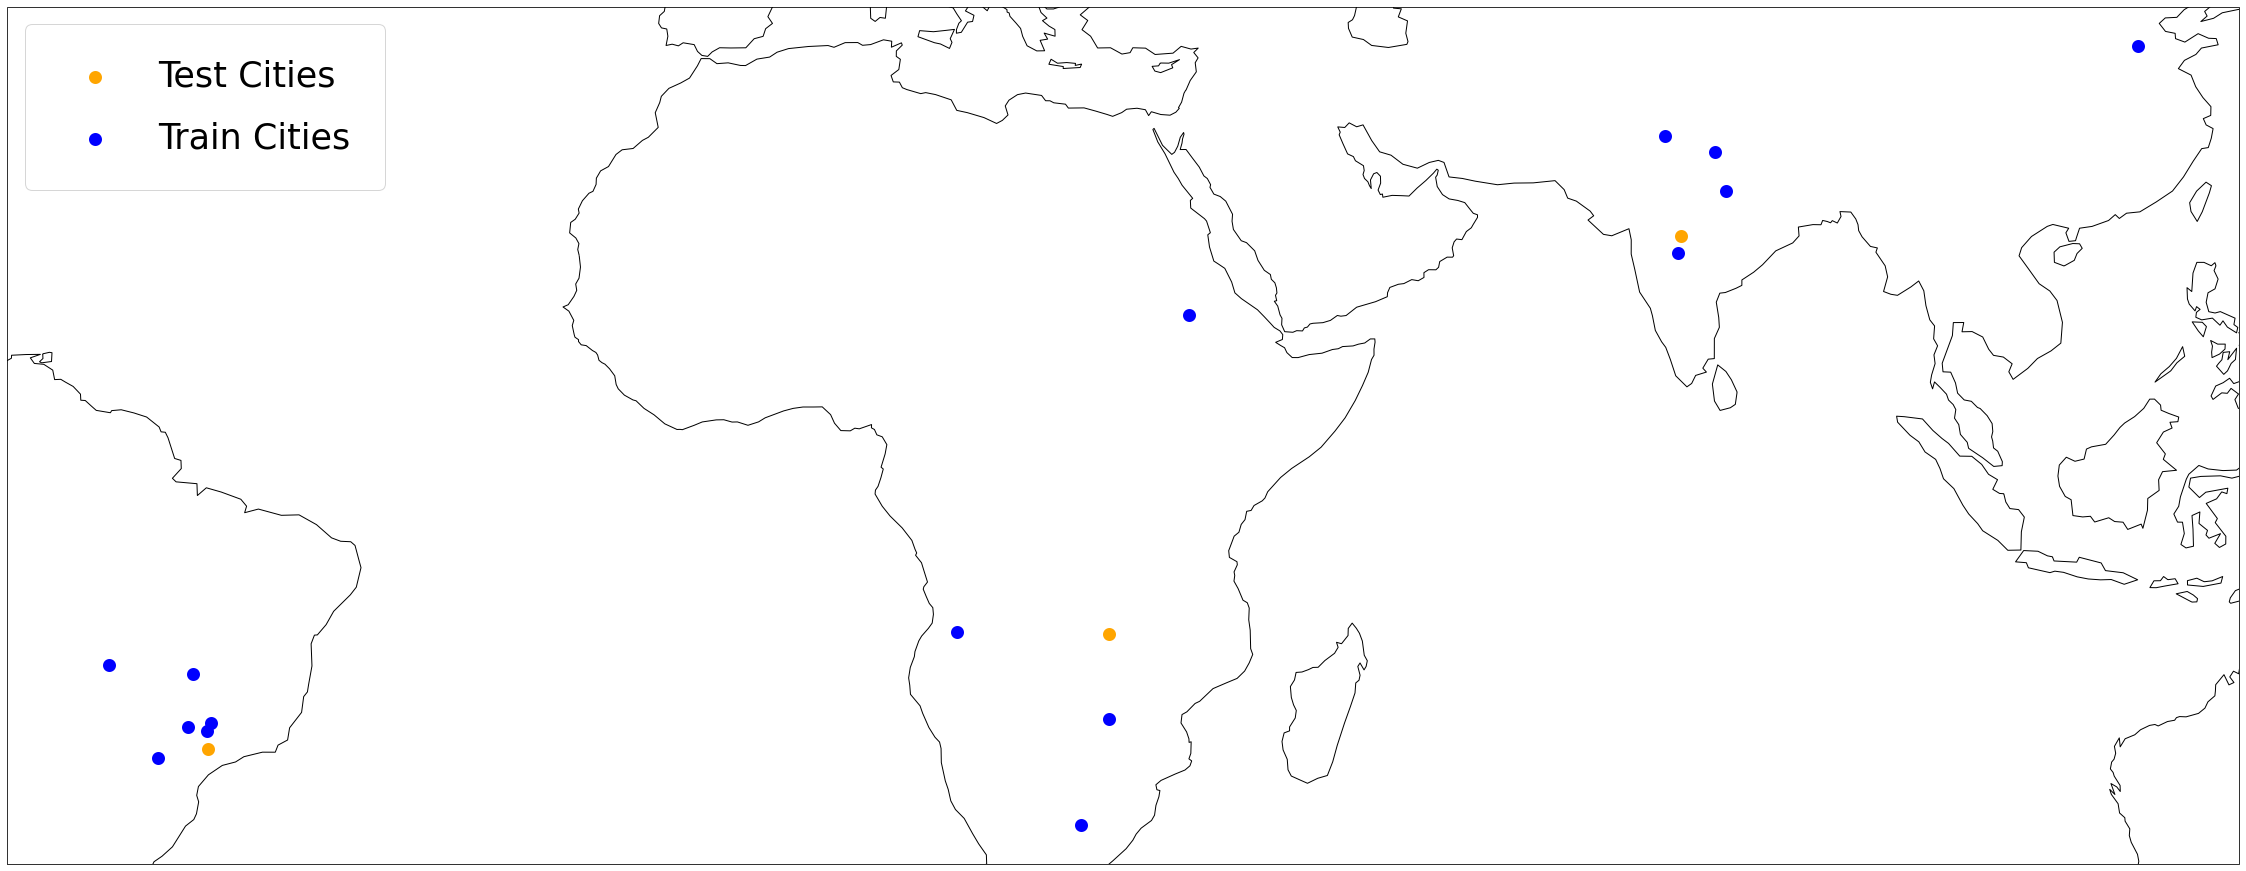

In [419]:
#Display train and test cities
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))

test_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
test_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

train_lats = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
train_lons = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(test_lons, test_lats, zorder=5,color='orange', label='Test Cities', linewidths = 7.0)
ax.scatter(train_lons, train_lats, zorder=5,color='blue', label='Train Cities', linewidths = 7.0)

ax.legend(loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)

Muliple Linear Regression

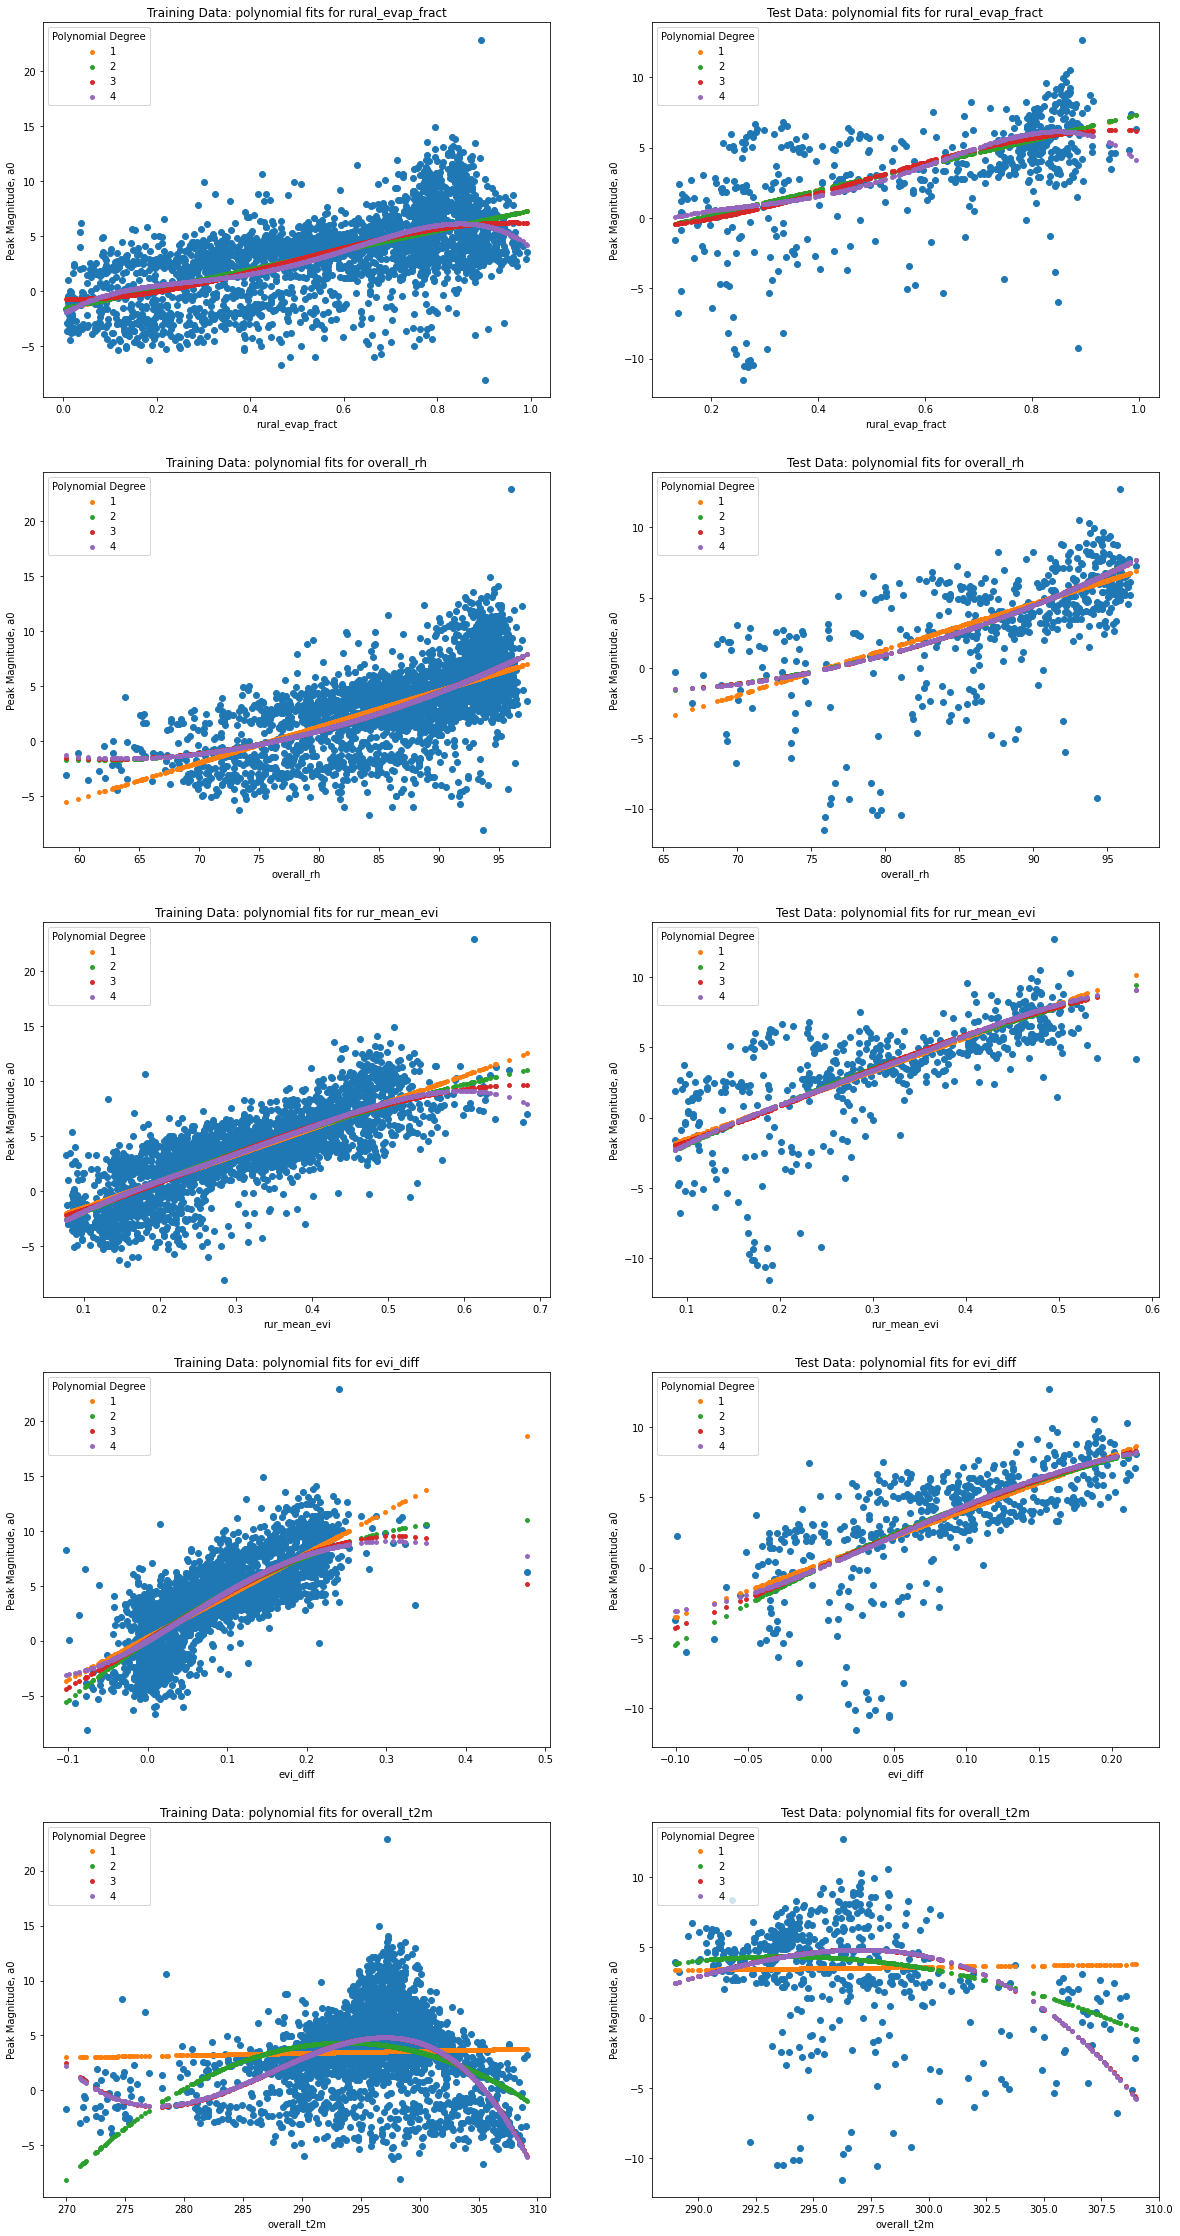

In [420]:
###### LINEAR REGRESSION ####################

#############################################
##### INPUT VARIABLES NOT NORMALISED ########
#############################################

#Linear Regression
#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree))  #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree))    #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


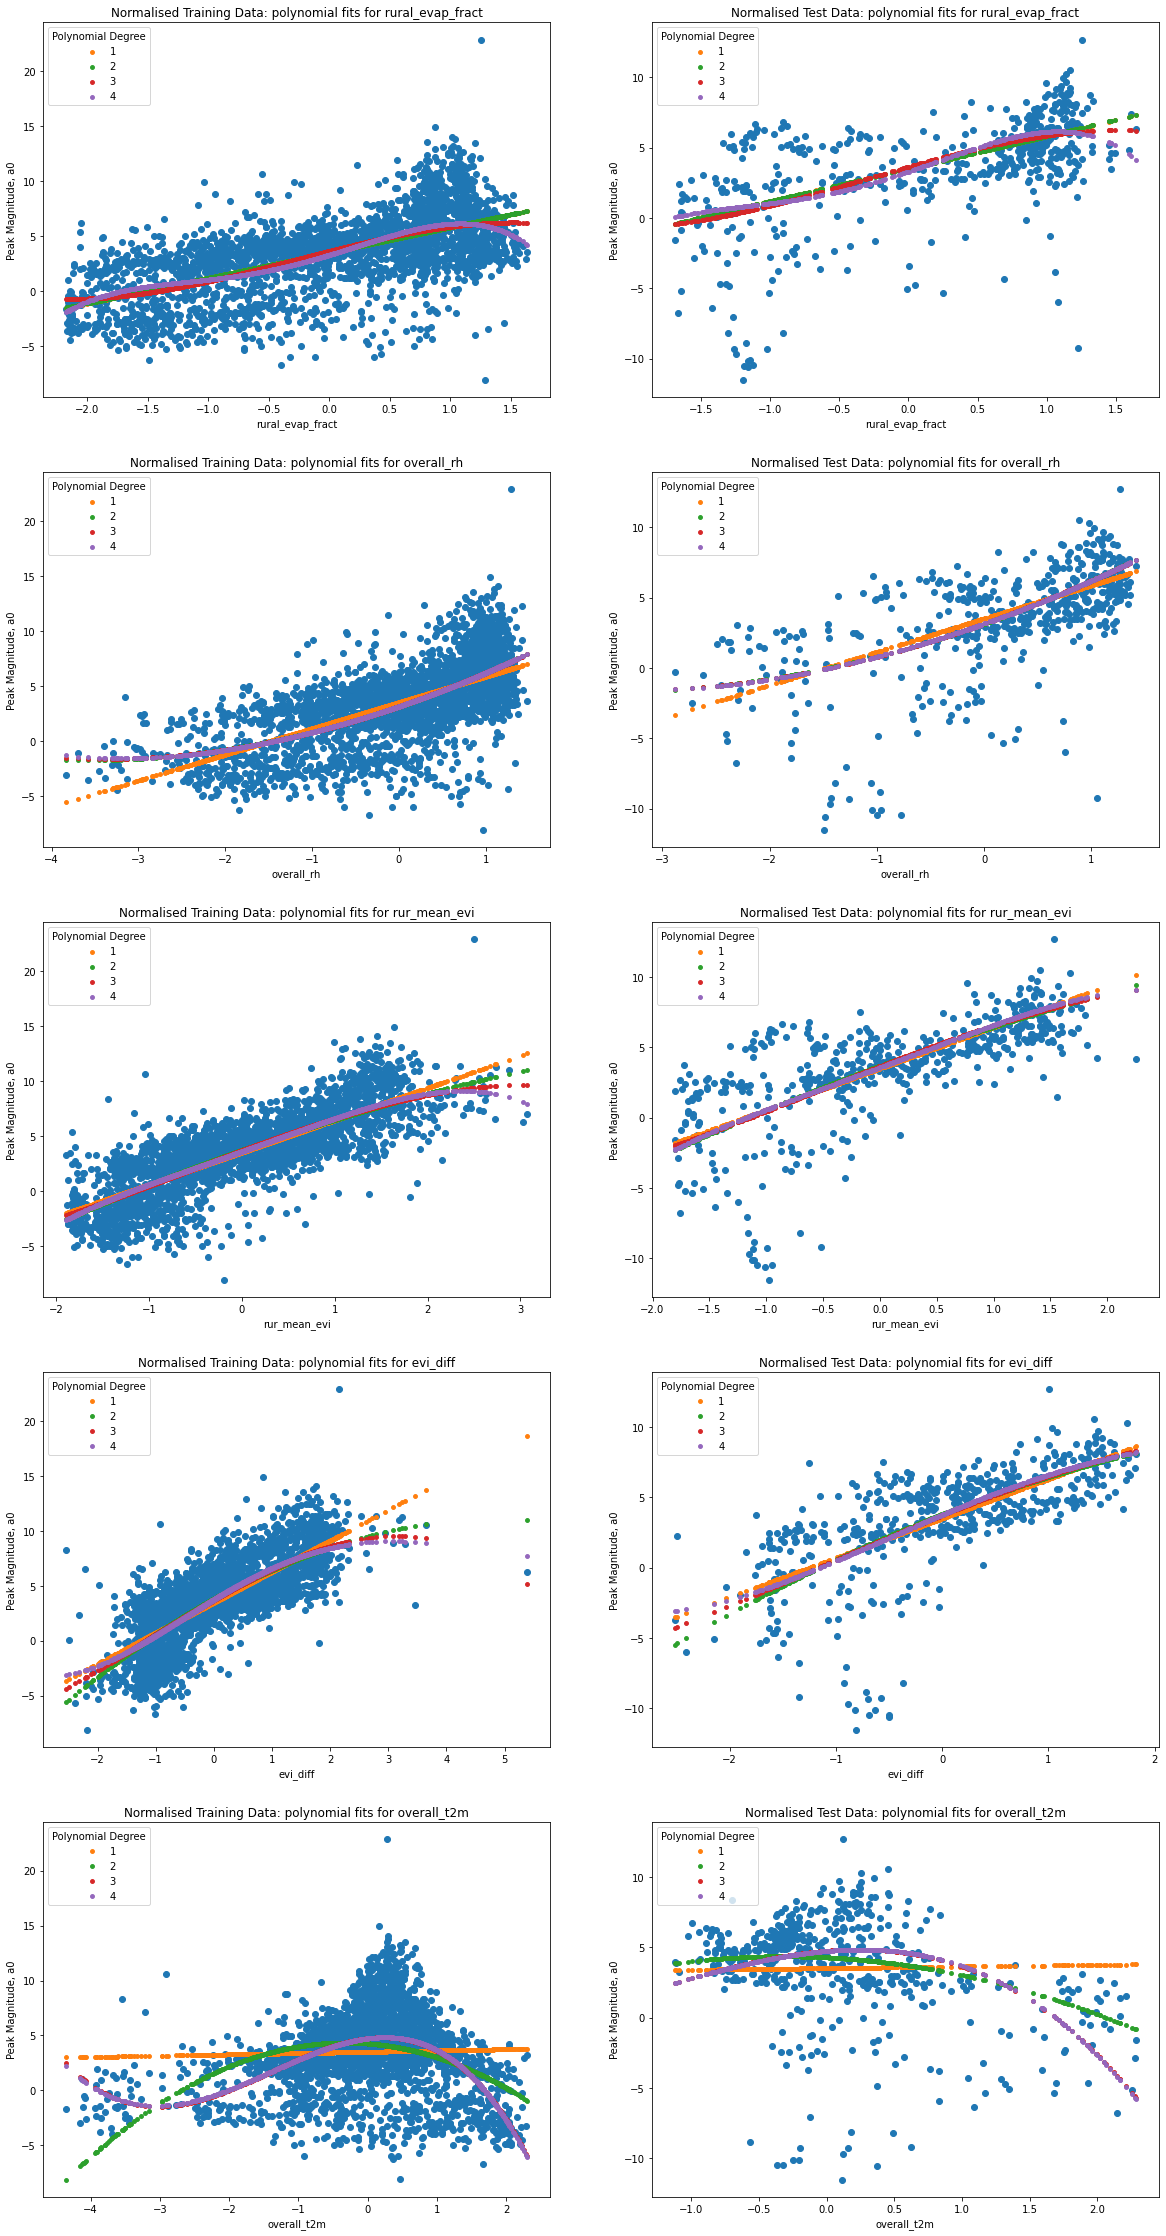

In [421]:
###### LINEAR REGRESSION ####################

#############################################
##### NORMALISED INPUT VARIABLES ############
#############################################

#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train_norm[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test_norm[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree)) #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree))   #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


In [141]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
####### Creating the model #######
##################################
#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(predictor_variables[i],':', lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  3.507446722987034
Coefficients--
overall_evap_fract : 0.34883526273612414
evi_diff : 2.3106162682111004
rural_ssr : 0.4643053395328474
urb_mean_evi : 1.0163120756326458
Training Metrics-- RMSE: 2.104263336350883 R-square: 0.6754642706922495 MAE: 1.628708935894562
Test Metrics-- RMSE: 2.710755210115402 R-square: 0.49103864512069884 MAE: 1.8046065933736815


In [59]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
##### SUMMARY STATISTICS #########
##################################
#Carried out again in stats models library to get the p-values (no function to calculate these in scikit learn)
X_train1 = X_train_norm.to_numpy()     #required form of X is an array
X_train2 = sm.add_constant(X_train1)   #add intercept to model
est = sm.OLS(y_train, X_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     a0   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     423.7
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:09:03   Log-Likelihood:                -5716.8
No. Observations:                2750   AIC:                         1.147e+04
Df Residuals:                    2732   BIC:                         1.158e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5099      0.037     94.829      0.0

In [143]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## LINEAR REGRESSION #################

######## MAKE SURE THE  LINEAR REGRESSION MODEL HAS BEEN FIT BEFORE RUNNING THIS ##############################

#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values
r2_list = []
for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                                  #predictors
    X_data_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns) #transform only
    y_data_city = data_city[target_variable]                                                      #target
    
    y_city_pred = lin_reg.predict(X_data_city_norm)
    
    r2_score_city = r2_score(y_data_city, y_city_pred)                                            #predict the r2 score
    
    r2_list.append(r2_score_city)
    

In [165]:
kg = CITY_COUNTRY_lat_lon.koppen_climate.values

pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})

,city,r2,Koppen_Geiger
0,Huambo,0.540956,Cwb
1,Anapolis,0.679805,Aw
2,Cuiaba,0.408670,Aw
3,Franca,0.587471,Cwa
4,Maringa,0.401204,Cfa
5,Piracicaba,0.711152,Aw
6,Ribeirao,0.427083,Aw
7,Sao_Jose_Do_Rio_Preto,0.563853,Aw
8,Linqing,0.447908,BSk
9,Akola,0.101092,BSh


In [60]:
############################################
#### PERMUTATIONS OF LINEAR REGRESSIONS ####
############################################

#linear regression to test all permutations of predictor variables
#create a dataframe to fill
n = len(predictor_variables)
whole_grid = np.ones((1, n), dtype=int) #start with the case where all variables are included

for i in range(n-1):
    m = i+1
    which = np.array(list(itertools.combinations(range(n), m)))
    grid = np.zeros((len(which), n), dtype="int8")

    #add the combinations into the grid
    grid[np.arange(len(which))[None].T, which] = 1

    whole_grid = np.vstack((whole_grid, grid))
    
all_models = pd.DataFrame(data = whole_grid, columns = predictor_variables) #create a dataframe with all the combinations
all_models['AIC'] = np.nan           #add in the test statistics
all_models['Ftest_pvalue']= np.nan
all_models['rmse'] = np.nan
all_models['rsquared'] = np.nan
all_models['test_rmse'] = np.nan
all_models['test_rsquared'] = np.nan

#go through the table and calculate test statistics for models including combinations of pred variables
for i in range(len(all_models)):
    row = all_models.iloc[i] #take the row
    variable_list = []
    for p, predictor in enumerate(predictor_variables):
        if row[p] == 1:
            variable_list.append(predictor)         #create list of the variables which are used in the row
    
    X_train_temp = X_train_norm[variable_list]      #select the train variables to be used
    X_test_temp = X_test_norm[variable_list]
    #not using test data for model validation/ selection as it must remain untouched
    #carry out the linear regression
    X_train_temp1 = X_train_temp.to_numpy()         #required form of X is an array
    X_train_temp2 = sm.add_constant(X_train_temp1)  #add intercept to model
    
    est = sm.OLS(y_train, X_train_temp2)
    est2 = est.fit()
    y_train_pred = est2.predict(X_train_temp2)
    
    #calculate the y test prediction
    
    X_test_temp1 = X_test_temp.to_numpy()                     #required form of X is an array
    X_test_temp2 = sm.add_constant(X_test_temp1)              #add intercept to model
    y_test_pred = est2.predict(X_test_temp2)                  #predict the test dataset
    
    #add in the test statistics
    all_models.loc[i,'AIC'] =  est2.aic                                 #AIC
    all_models.loc[i,'Ftest_pvalue']= est2.f_pvalue                     #f statistic p value
    all_models.loc[i,'rmse'] = rmse(y_train, y_train_pred)              #train rmse
    all_models.loc[i,'rsquared'] =est2.rsquared                         #train r square
    all_models.loc[i,'test_rmse'] = rmse(y_test, y_test_pred)           #test rmse
    all_models.loc[i,'test_rsquared'] = r2_score(y_test, y_test_pred)   #test r square
    
    
#save the table as a pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','predictive_models')) 
with open('all_variables_lin_reg.pkl', 'wb') as f:
    pickle.dump(all_models, f)

#for each number of predictor variables, select the model with the best r-squared
#add in the number of variables used in each model
all_models['num_variables'] = all_models[predictor_variables].sum(axis = 1)

#create empty dataframe to be filled
best_models = pd.DataFrame()
#select the models for each variable which have the best r-square
#best_models 
for i in range(len(predictor_variables)):
    max_rsquare = max(all_models[all_models['num_variables'] == (i+1)].rsquared)
    rows = all_models[(all_models['rsquared'] == max_rsquare)& (all_models['num_variables'] == (i+1))]
    best_models = best_models.append(rows)

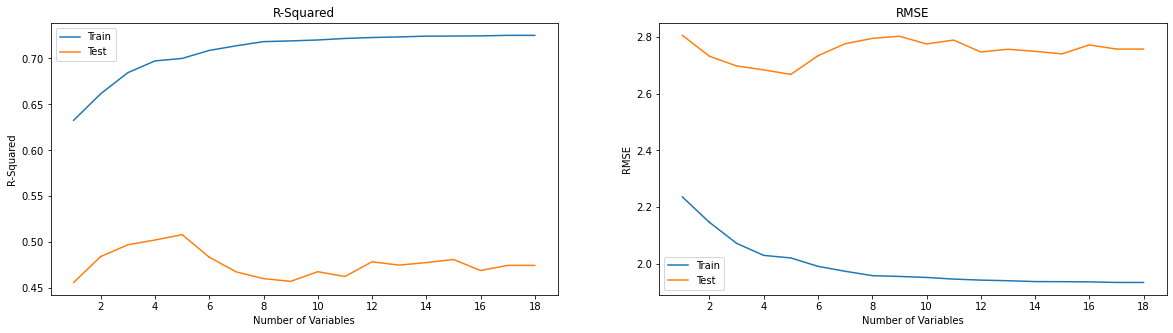

In [69]:
#plot the number of variables against the r-squared, AIC and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(best_models.num_variables, best_models.rsquared, label = 'Train')
axes[0].plot(best_models.num_variables, best_models.test_rsquared, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(best_models.num_variables, best_models.rmse, label = 'Train')
axes[1].plot(best_models.num_variables, best_models.test_rmse, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [461]:
#Using cross validation to determine the number of variables used (the hyperparameter in this case)
n = len(predictor_variables) 
#cross-validation scheme, 5 fold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, n+1))}]

#perform grid search

lin_reg = LinearRegression()           #specify model
lin_reg.fit(X_train_norm, y_train)     #fit the model 
rfe = RFE(lin_reg)                     #feature selection

#Use cross validation
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007189,0.002700,0.001595,0.000489,1,{'n_features_to_select': 1},0.595548,0.597881,0.594870,0.524084,...,0.572900,0.029781,5,0.569962,0.569406,0.568987,0.586660,0.580518,0.575107,0.007200
1,0.005377,0.001188,0.001997,0.000898,2,{'n_features_to_select': 2},0.657208,0.650170,0.648522,0.600784,...,0.631845,0.024822,4,0.627992,0.629694,0.629229,0.641109,0.641251,0.633855,0.006007
2,0.004787,0.000746,0.002194,0.000746,3,{'n_features_to_select': 3},0.729576,0.683184,0.703721,0.664467,...,0.681839,0.034448,3,0.673320,0.684535,0.678444,0.688749,0.697642,0.684538,0.008395
3,0.002989,0.000004,0.001810,0.000757,4,{'n_features_to_select': 4},0.743096,0.683246,0.720789,0.671848,...,0.693936,0.033494,2,0.685960,0.700330,0.689914,0.702713,0.707964,0.697376,0.008190
4,0.002584,0.000482,0.001397,0.000488,5,{'n_features_to_select': 5},0.746809,0.686207,0.726311,0.668576,...,0.695970,0.035465,1,0.688410,0.702963,0.691571,0.706641,0.710980,0.700113,0.008704


In [450]:
model_cv.best_params_

{'n_features_to_select': 5}

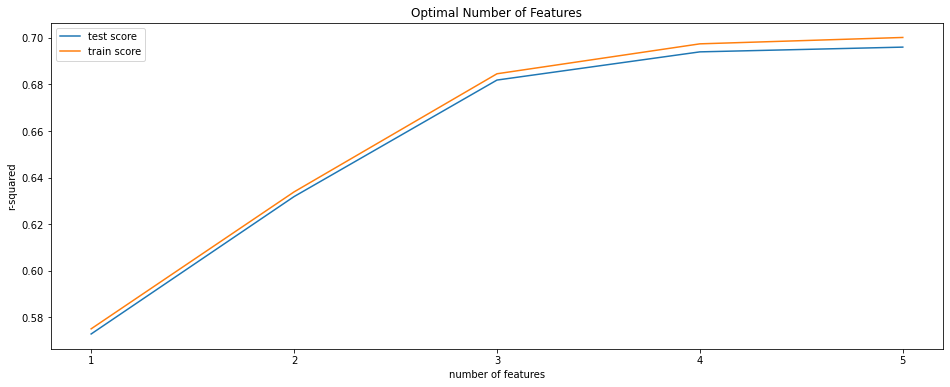

In [451]:
# plotting cv results
fig, axes = plt.subplots(1,1, figsize = (16, 6))

axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
axes.set(xlabel= 'number of features', ylabel='r-squared', title = "Optimal Number of Features")
axes.legend(['test score', 'train score'], loc='upper left')
xa = axes.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [459]:
#Multiple Linear Regression (MLR) (degree 2 (polynomial))
##################################
####### Creating the model #######
##################################

#create polynomial inputs, 
poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(X_train_norm)

#create the lin reg model
lin_reg = LinearRegression()

#then feed polynomials to lin reg model
lin_reg.fit(X_poly, y_train)
#predict the training 
y_train_pred = lin_reg.predict(X_poly)
#predict the test
X_poly_test = poly_features.fit_transform(X_test_norm)
y_test_pred = lin_reg.predict(X_poly_test)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
poly_predictor_vars = poly_features.get_feature_names(predictor_variables)
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(poly_predictor_vars[i],':',lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  3.815488851578122
Coefficients--
1 : 0.0
overall_rh : 1.6474609303409462
rural_ssr : 1.0343336038396287
evi_diff : 2.217887173353871
overall_rh^2 : -0.01825731063169926
overall_rh rural_ssr : -0.3208114557045203
overall_rh evi_diff : 0.20355333091837358
rural_ssr^2 : -0.15929544837588394
rural_ssr evi_diff : 0.5649479011322004
evi_diff^2 : -0.2642898268154235
Training Metrics-- RMSE: 2.0123071959595125 R-square: 0.7032088814157595 MAE: 1.5258047714395184
Test Metrics-- RMSE: 2.7659045231970856 R-square: 0.47011872259435206 MAE: 1.8564157513358508


Ridge Regression

In [108]:
##########################
#### RIDGE REGRESSION ####
##########################

folds = 5    #define the number of folds (K)

#define regression model
ridge_reg = Ridge(fit_intercept=True)
#specify the hyperparameters to test
hyper_params = {'alpha':[1, 10, 20,30,40,50,60,70,80,90, 100]}
#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
#fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002393,4.879942e-04,0.001396,4.886557e-04,1,{'alpha': 1},0.693023,0.560561,0.651030,0.325440,...,0.540049,0.131967,1,0.694849,0.667565,0.703226,0.719296,0.691343,0.695256,0.016874
1,0.001995,4.101908e-07,0.001396,4.884025e-04,10,{'alpha': 10},0.694046,0.559437,0.651260,0.324566,...,0.539847,0.132521,2,0.694815,0.667527,0.703187,0.719258,0.691311,0.695220,0.016874
2,0.002593,4.887342e-04,0.001996,8.934608e-04,20,{'alpha': 20},0.695011,0.558092,0.651404,0.323403,...,0.539505,0.133142,3,0.694719,0.667422,0.703079,0.719152,0.691218,0.695118,0.016873
3,0.002194,3.986125e-04,0.001396,4.885777e-04,30,{'alpha': 30},0.695819,0.556657,0.651447,0.322079,...,0.539059,0.133762,4,0.694572,0.667258,0.702911,0.718991,0.691075,0.694961,0.016872
4,0.002598,4.931056e-04,0.001795,3.988982e-04,40,{'alpha': 40},0.696491,0.555140,0.651404,0.320628,...,0.538526,0.134379,5,0.694379,0.667043,0.702694,0.718784,0.690889,0.694758,0.016873
5,0.002797,3.878650e-04,0.001995,3.015783e-07,50,{'alpha': 50},0.697045,0.553549,0.651288,0.319077,...,0.537918,0.134989,6,0.694150,0.666784,0.702436,0.718538,0.690665,0.694514,0.016875
6,0.002787,3.963866e-04,0.002394,4.888698e-04,60,{'alpha': 60},0.697496,0.551891,0.651107,0.317447,...,0.537247,0.135591,7,0.693888,0.666486,0.702141,0.718260,0.690408,0.694237,0.016879
7,0.002790,7.480169e-04,0.001796,7.469046e-04,70,{'alpha': 70},0.697856,0.550172,0.650871,0.315755,...,0.536523,0.136183,8,0.693598,0.666154,0.701816,0.717955,0.690122,0.693929,0.016885
8,0.001995,9.536743e-08,0.001197,3.988266e-04,80,{'alpha': 80},0.698135,0.548397,0.650586,0.314016,...,0.535753,0.136765,9,0.693284,0.665792,0.701464,0.717627,0.689811,0.693596,0.016893
9,0.001995,1.784161e-07,0.001596,4.886360e-04,90,{'alpha': 90},0.698344,0.546572,0.650257,0.312240,...,0.534942,0.137335,10,0.692948,0.665404,0.701090,0.717279,0.689477,0.693240,0.016903


In [109]:
#Performance stats for ridge regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_ridge_mse = mean_squared_error(y_train, y_train_pred)
train_ridge_rmse = np.sqrt(train_ridge_mse)
#r-square
train_ridge_r2 = r2_score(y_train, y_train_pred)
#mae
train_ridge_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_ridge_rmse, 'R-square:', train_ridge_r2, 'MAE:', train_ridge_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_ridge_mse = mean_squared_error(y_test, y_test_pred)
test_ridge_rmse = np.sqrt(test_ridge_mse)
#r-square
test_ridge_r2 = r2_score(y_test, y_test_pred)
#mae
test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_ridge_rmse, 'R-square:', test_ridge_r2, 'MAE:', test_ridge_mae)


Training Metrics-- RMSE: 2.0208998098219024 R-square: 0.6998995422257586 MAE: 1.545504525997338
Test Metrics-- RMSE: 2.667675438189789 R-square: 0.508316689083153 MAE: 1.76539432992538


Random Forest regression (RFR)

In [160]:
##################################
#### RANDOM FOREST REGRESSION ####
##################################

forest_reg = RandomForestRegressor()                                  #define the model

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 1232 candidates, totalling 6160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6160 out of 6160 | elapsed: 18.0min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021143,3.419832e-03,0.001995,3.504023e-07,10,1,2,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.594657,...,0.361806,0.192389,1179,0.844340,0.834747,0.855567,0.858786,0.848758,0.848440,0.008512
1,0.036303,2.862777e-03,0.002195,3.990412e-04,10,1,2,10,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.628207,...,0.394239,0.192995,1012,0.852082,0.853152,0.867891,0.880158,0.857036,0.862064,0.010637
2,0.065824,2.132481e-07,0.003591,4.885387e-04,10,1,2,20,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.626276,...,0.409155,0.192373,780,0.862140,0.860016,0.873319,0.882713,0.869065,0.869451,0.008167
3,0.132445,4.155387e-03,0.005785,3.989697e-04,10,1,2,40,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.649833,...,0.418638,0.189318,547,0.862442,0.857814,0.878287,0.888986,0.869259,0.871358,0.011190
4,0.203360,1.493523e-02,0.007979,6.308271e-04,10,1,2,60,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.648790,...,0.419525,0.186783,513,0.864013,0.865393,0.876096,0.887592,0.868678,0.872354,0.008692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,0.056448,4.879374e-04,0.003192,3.988266e-04,None,15,15,20,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.662616,...,0.434180,0.194090,233,0.736052,0.731155,0.750070,0.769222,0.739524,0.745205,0.013520
1228,0.110313,2.394411e-03,0.005186,7.462637e-04,None,15,15,40,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.670436,...,0.438008,0.192946,146,0.738918,0.732346,0.752143,0.771599,0.742957,0.747593,0.013610
1229,0.154193,2.414695e-03,0.006386,4.887925e-04,None,15,15,60,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.670046,...,0.440674,0.189930,46,0.739237,0.731836,0.753785,0.770152,0.742794,0.747561,0.013330
1230,0.205597,2.288130e-03,0.007980,6.351999e-04,None,15,15,80,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.672885,...,0.439618,0.193918,81,0.739130,0.732980,0.753928,0.771307,0.743229,0.748115,0.013456


In [161]:
cv_results[cv_results['rank_test_score'] < 10].sort_values(by = ['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
651,0.014760,0.000399,0.001995,1.168008e-07,60,15,5,5,"{'max_depth': 60, 'min_samples_leaf': 15, 'min...",0.670898,...,0.448404,0.191582,1,0.728758,0.717991,0.740125,0.761976,0.739376,0.737645,0.014604
86,0.057246,0.002326,0.003591,4.885387e-04,10,15,2,20,"{'max_depth': 10, 'min_samples_leaf': 15, 'min...",0.670886,...,0.446189,0.182470,2,0.737851,0.729802,0.750556,0.770433,0.740144,0.745757,0.014004
437,0.106708,0.002654,0.004981,1.628760e-05,40,15,10,40,"{'max_depth': 40, 'min_samples_leaf': 15, 'min...",0.675578,...,0.444470,0.190387,3,0.738863,0.731697,0.753294,0.770425,0.740873,0.747030,0.013611
1205,0.027726,0.000398,0.002194,3.990103e-04,None,15,2,10,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.673871,...,0.443961,0.183859,4,0.734230,0.728799,0.749138,0.768695,0.736023,0.743377,0.014314
660,0.053471,0.000806,0.003393,4.885409e-04,60,15,10,20,"{'max_depth': 60, 'min_samples_leaf': 15, 'min...",0.674814,...,0.443494,0.190700,5,0.737981,0.728293,0.752456,0.767193,0.741332,0.745451,0.013334
209,0.268882,0.016848,0.009578,7.969223e-04,20,15,5,100,"{'max_depth': 20, 'min_samples_leaf': 15, 'min...",0.677437,...,0.443080,0.191450,6,0.740461,0.732746,0.754106,0.771196,0.743249,0.748352,0.013318
320,0.209637,0.003422,0.008383,4.917228e-04,30,15,5,80,"{'max_depth': 30, 'min_samples_leaf': 15, 'min...",0.675653,...,0.442852,0.191656,7,0.738391,0.733243,0.754008,0.771219,0.741918,0.747756,0.013579
1004,0.105330,0.001723,0.004787,3.982073e-04,90,15,15,40,"{'max_depth': 90, 'min_samples_leaf': 15, 'min...",0.674932,...,0.442695,0.187167,8,0.740037,0.731636,0.752910,0.769858,0.741675,0.747223,0.013191
650,0.309557,0.011904,0.011383,8.076614e-04,60,15,2,100,"{'max_depth': 60, 'min_samples_leaf': 15, 'min...",0.677255,...,0.442690,0.193769,9,0.739799,0.733083,0.754904,0.770748,0.742496,0.748206,0.013304


In [162]:
#Performance stats for random forest regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_forest_mse = mean_squared_error(y_train, y_train_pred)
train_forest_rmse = np.sqrt(train_forest_mse)
#r-square
train_forest_r2 = r2_score(y_train, y_train_pred)
#mae
train_forest_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_forest_rmse, 'R-square:', train_forest_r2, 'MAE:', train_forest_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_forest_mse = mean_squared_error(y_test, y_test_pred)
test_forest_rmse = np.sqrt(test_forest_mse)
#r-square
test_forest_r2 = r2_score(y_test, y_test_pred)
#mae
test_forest_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_forest_rmse, 'R-square:', test_forest_r2, 'MAE:', test_forest_mae)


Training Metrics-- RMSE: 1.8807399662220232 R-square: 0.7407493540004241 MAE: 1.427805999886322
Test Metrics-- RMSE: 2.7912372790701325 R-square: 0.4603679703342818 MAE: 1.9733890551076247


In [163]:
model_cv.best_params_

{'max_depth': 60,
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'n_estimators': 5}

Gaussian Process Regression

In [ ]:
#############################################
######## GAUSSIAN PROCESS REGRESSION ########
#############################################




In [ ]:
#generalised additive model (GAM) 